In [1]:
# Importing necessary libraries
from os import path
import torch
from tqdm import tqdm
import torchvision.datasets as dset
from torch .autograd import Variable
import torch.nn as nn
import  torch.optim as optim
import os
torch.cuda.empty_cache()
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image
import torchvision.utils as vutils
from IPython.display import clear_output
import datetime
from torch.utils.data import Dataset, DataLoader

In [2]:
# Checking torch version
torch.__version__

'1.8.1'

In [ ]:
# Initializing root directories
training_dir = "./train"
test_dir = "./test"

In [ ]:
# Making custom pytorch dataset
folder_dataset = dset.ImageFolder(root=training_dir)

In [ ]:
# Making custom pytorch datset class
scale = 255
class get_Dataset(Dataset):
    def __init__(self, imageFolderDataset):
        self.imageFolderDataset = imageFolderDataset 
        self.len = int(len(self.imageFolderDataset.imgs)/2)
        self.object = np.ones((self.len, 3, 256, 256))
        self.target = np.ones((self.len, 3, 256, 256))
        for i in range(0, self.len, 1):
            x = cv2.resize(cv2.imread(self.imageFolderDataset.imgs[i+2270][0]), (256,256))
            bo,go,ro = cv2.split(x)           # get b, g, r
            rgb_imgo = cv2.merge([ro,go,bo]) 
            self.object[i] = rgb_imgo.transpose(2, 1, 0)
            y = cv2.resize(cv2.imread(self.imageFolderDataset.imgs[i][0]), (256,256))
            bp,gp,rp = cv2.split(y)           # get b, g, r
            rgb_imgp = cv2.merge([rp,gp,bp]) 
            self.target[i] = rgb_imgp.transpose(2, 1, 0)
            #print(i)
        # Normalization between -1 to 1
        self.object = torch.from_numpy(((self.object/(scale / 2)) -1 )).double()
        self.target = torch.from_numpy(((self.target/(scale / 2)) -1 )).double()

    def __getitem__(self,index):
        return self.object[index], self.target[index]        
        
    def __len__(self):
        return self.len  

In [ ]:
train_dataset = get_Dataset(imageFolderDataset = folder_dataset)    

In [ ]:
train_loader = DataLoader(train_dataset , batch_size = 16 , shuffle = True )

In [3]:
class DownSampleConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, activation=True, batchnorm=True):
        """
        Paper details:
        - C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        """
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        return x

In [4]:
class UpSampleConv(nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel=4,
        strides=2,
        padding=1,
        activation=True,
        batchnorm=True,
        dropout=False
    ):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU(True)

        if dropout:
            self.drop = nn.Dropout2d(0.5)

    def forward(self, x):
        x = self.deconv(x)
        if self.batchnorm:
            x = self.bn(x)

        if self.dropout:
            x = self.drop(x)
        return x

In [5]:
# Generator
class G(nn.Module):

    def __init__(self):
        """
        Paper details:
        - Encoder: C64-C128-C256-C512-C512-C512-C512-C512
        - All convolutions are 4×4 spatial filters applied with stride 2
        - Convolutions in the encoder downsample by a factor of 2
        - Decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
        """
        super().__init__()

        # encoder/donwsample convs
        self.encoders = [
            DownSampleConv(3, 64, batchnorm=False),  # bs x 64 x 128 x 128
            DownSampleConv(64, 128),  # bs x 128 x 64 x 64
            DownSampleConv(128, 256),  # bs x 256 x 32 x 32
            DownSampleConv(256, 512),  # bs x 512 x 16 x 16
            DownSampleConv(512, 512),  # bs x 512 x 8 x 8
            DownSampleConv(512, 512),  # bs x 512 x 4 x 4
            DownSampleConv(512, 512),  # bs x 512 x 2 x 2
            DownSampleConv(512, 512, batchnorm=False),  # bs x 512 x 1 x 1
        ]

        # decoder/upsample convs
        self.decoders = [
            UpSampleConv(512, 512, dropout=True),  # bs x 512 x 2 x 2
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 4 x 4
            UpSampleConv(1024, 512, dropout=True),  # bs x 512 x 8 x 8
            UpSampleConv(1024, 512),  # bs x 512 x 16 x 16
            UpSampleConv(1024, 256),  # bs x 256 x 32 x 32
            UpSampleConv(512, 128),  # bs x 128 x 64 x 64
            UpSampleConv(256, 64),  # bs x 64 x 128 x 128
        ]
        self.decoder_channels = [512, 512, 512, 512, 256, 128, 64]
        self.final_conv = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)

            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            # print(x.shape, skip.shape)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        # print(x.shape)
        x = self.final_conv(x)
        return self.tanh(x)

In [ ]:
#weights initializiation
def _weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
# Creating the generator
netG = G().double().cuda()
netG.apply(_weights_init)
clear_output()
#netG(Variable(input)).shape

In [6]:
# Discriminator
class D(nn.Module):

    def __init__(self):
        super().__init__()
        self.d1 = DownSampleConv(6, 64, batchnorm=False)
        self.d2 = DownSampleConv(64, 128)
        self.d3 = DownSampleConv(128, 256)
        self.d4 = DownSampleConv(256, 512)
        self.final = nn.Conv2d(512, 1, kernel_size = 1)
        self.sig = nn.Sigmoid()

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        xn = self.final(x3)
        xs = self.sig(xn)
        return xs

In [ ]:
# Creating the discriminator
netD = D().double().cuda()
netD.apply(_weights_init)
clear_output()
#netD(torch.cat((Variable(input), Variable(label)) , dim=1))

In [ ]:
criterion = nn.BCEWithLogitsLoss() # We create a criterion object that will measure the error between the prediction and the target.
L1loss=nn.L1Loss()
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999)) # We create the optimizer object of the discriminator.
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999)) # We create the optimizer object of the generator.

In [ ]:
# clearing the previous result
sketch_result = "./results6/"

In [ ]:
max_epoch = 100
alpha = 100
for epoch in range(max_epoch): # We iterate over 25 epochs.
    netG.train()
    netD.train()

    for i, data in enumerate(train_loader, 0):     # We iterate over the images of the dataset.

        # 1st Step: Updating the weights of the neural network of the discriminator
        netD.zero_grad() 
        # Training the discriminator with a real image of the dataset
        obj , label  =  data
        obj = Variable(obj.cuda())
        label = Variable(label.cuda())
        target = torch.ones((label.size()[0] ,1, 16 , 16)).fill_(1).double().cuda()


    #---------------------------------------------------------------------------------------------------------------------------
        targetv = Variable(target)
        output = netD(obj, label) 
        # print("targetv.shape : ", targetv.shape )
        # print(output.shape)
        # print(label.shape)

        errD_color = criterion(output , targetv)
        errD_color = errD_color*0.5
        errD_color.backward(retain_graph=True)

    #--------------------------------------------------------------------------------------------------------------------        
        fake = netG(obj) 
        targetv = Variable(target.fill_(0)) 
        output = netD(obj , fake)

        errD_fake = criterion(output, targetv) 
        errD_fake = errD_fake*0.5
        errD = (errD_color + errD_fake)
        #errD.backward(retain_graph = True)
        errD_fake.backward(retain_graph=True)
        optimizerD.step()

    #---------------------------------------------------------------------------------------------------------------------------        

        # 2nd Step: Updating the weights of the neural network of the generator

        netG.zero_grad() 
        targetv = Variable(target.fill_(1))
        output = netD(obj, fake) 
        errG = criterion(output, targetv)
        errG_L1 = L1loss(fake , label)
        errG1 = errG  +  alpha *  errG_L1
        errG1.backward() 
        optimizerG.step() 
        print('[%d/%d] [%d/%d] Loss_D: %.20f Loss_G: %.20f' % (epoch, max_epoch, i, len(train_loader), errD.item(), errG1.item()/alpha))

        if i % 141 == 0 and i != 0:
            temp =obj.cpu().data
            #temp = np.transpose(temp, [0, 3, 2, 1])
            vutils.save_image(temp , '%sepoch_%2d_%03d_object.png' % ( sketch_result ,epoch   , i) , normalize=True)
            temp =fake.cpu().data
            print(temp.shape)
            #temp = np.transpose(temp, [0, 3, 2, 1])
            vutils.save_image(temp , '%sepoch_%2d_%03d_fromGenerator.png' % ( sketch_result ,epoch   , i) , normalize=True)
            temp =label.cpu().data        
            #temp = np.transpose(temp, [0, 3, 2, 1])            
            vutils.save_image(temp , '%sepoch_%2d_%03d_target.png' % ( sketch_result ,epoch   , i) , normalize=True)
            # saving the loss in file
            f=open(sketch_result + "LOG.txt", "a+")
            f.write('[%d/%d] [%d/%d] Loss_D: %.20f Loss_G: %.20f\n' % (epoch, max_epoch, i, len(train_loader), errD.item(), errG1.item()/alpha))
            f.close()
            clear_output()
 

In [ ]:
# Saving the model
torch.save(netD.cuda().state_dict(), "./models/dis_2dat_256.pt")
print("Discriminator Saved Successfully")
torch.save(netG.cuda().state_dict(), "./models/gen_2dat_256.pt")
print("Generator Saved Successfully")

In [7]:
generator_test = G().double().cuda()

In [8]:
generator_test.load_state_dict(torch.load("./models/gen_2dat_256.pt"))
generator_test.eval()

G(
  (final_conv): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tanh): Tanh()
  (encoders): ModuleList(
    (0): DownSampleConv(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2)
    )
    (1): DownSampleConv(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2)
    )
    (2): DownSampleConv(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2)
    )
    (3): DownSampleConv(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): L

In [9]:
path = "./test/sketches/0001.jpg"
img = cv2.resize(cv2.imread(path),  (256,256))

In [10]:
b,g,r = cv2.split(img)           # get b, g, r
rgb_img = cv2.merge([r,g,b]) 

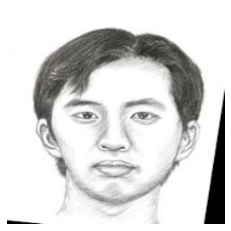

In [11]:
import matplotlib.pyplot as plt
plt.imshow(rgb_img)
plt.axis('off')
plt.show()

In [12]:
rgb_img = rgb_img.transpose(2,1,0)

In [13]:
rgb_img.shape

(3, 256, 256)

In [14]:
img_test = torch.from_numpy(((rgb_img/(255 / 2)) -1 )).double()

In [15]:
img_test=img_test.expand(1,3,256,256)

In [16]:
fake = generator_test(img_test.cuda())

In [17]:
fake.shape

torch.Size([1, 3, 256, 256])

In [18]:
fake = fake + 1
fake = fake*255
fake = fake*0.5

In [19]:
fake = fake.int()

In [20]:
fake_viz = fake[0].detach().cpu().numpy()

In [21]:
fake_viz.shape

(3, 256, 256)

In [22]:
fake_viz = fake_viz.transpose(2,1,0)

In [23]:
fake_viz.shape

(256, 256, 3)

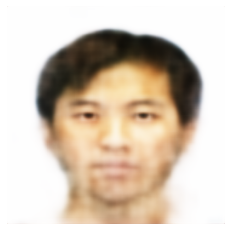

In [24]:
plt.imshow(fake_viz)
plt.axis('off')
plt.show()

In [ ]:
type(fake_viz)

In [ ]:
vutils.save_image(fake_viz , './test/train.png' , normalize=True)

In [ ]:
pwd